## Resting-State EEG Correlates of Sustained Attention in Healthy Ageing: Cross-Sectional Findings from the LEISURE Study

Created by Toomas Erik Anijärv and Alicia J. Campbell on 02.12.2022 (edited for publication purposes: 20.08.2024)

This notebook is a representation of EEG processing done for the publication, with one subject as an example.

You are free to use this or any other code from this repository for your own projects and publications. Citation or reference to the repository is not required, but would be much appreciated (see more on README.md).

In [ ]:
import mne, os
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum

# Set the current working directory to be the project main folder
os.chdir('/Users/aliciacampbell/Documents/GitHub/EEG-pyline')

import basic.arrange_data as arrange
import signal_processing.pre_process as pre_process
import signal_processing.spectral_analysis as spectr

**Locating the EEG files in folders** by define the experiment sub-folder (`exp_folder`), folder with raw EEG files (`raw_folder`), folder for exporting clean EEG files (`clean_folder`), and folder for exporting the results (`results_folder`).

During pre-processing, all the raw EEG files are cleaned from the `raw_folder/exp_folder` and later saved to `clean_folder/exp_folder`. For analysis, the same clean files are read in and worked on until the results are exported to `results_folder/exp_folder`.

In [2]:
### DEFINE ###
raw_folder = 'Data/Raw/'
clean_folder = 'Data/Clean/'
spectra_folder = 'Data/Spectra/'
results_folder = 'Results/'
savefinal_folder = 'Results/LEISURE/'

exp_folder = 'LEISURE/T1/EC'
exp_condition = 'EC_T1'

### PRE-PROCESSING

**Pre-processing** within this study includes initially reading the raw EEG files from `raw_folder/exp_folder`, setting montage (`biosemi32`), re-referencing the signals to `mastoid`, cropping the EEG signal to include only the `resting` part.

Furthermore, `0.5-30 Hz FIR filter` is designed (`zero-phase, Hamming window, order 6578`) and EOG channels are used to remove EOG-related noise with `signal-space projections (SSP)` as method.

Finally, artefacts are rejected with Autoreject package by removing epochs which exceed the global thereshold voltage level (`global AR`) and rest of the artefactual epochs are either removed or interpreted with `local AR`.

The clean EEG signals are exported to `clean_folder/exp_folder`.

In [3]:
### DEFINE ###
montage = 'biosemi32'
eog_channels = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'] # EOG channels + mastoids
stimulus_channel = 'Status'
erg_channel = 'Erg1'
reference = 'average' # average as reference
epochs_duration = 5
filter_design = dict(l_freq=0.5,h_freq=30,filter_length='auto',method='fir',
                     l_trans_bandwidth='auto',h_trans_bandwidth='auto',
                     phase='zero',fir_window='hamming',fir_design='firwin')

# Set the directory in progress and find all BDF (raw EEG) files in there
dir_inprogress = os.path.join(raw_folder,exp_folder)
export_dir = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress,'.bdf')

Files in Data/Raw/LEISURE/T1/EC read in: 1


In [4]:
for i in range(len(file_dirs)):
    # Read in the raw EEG data
    raw = mne.io.read_raw_bdf(file_dirs[i], infer_types=True, eog=eog_channels,
                              stim_channel=stimulus_channel)
    if 'Erg1' in raw.info['ch_names']:
        raw = raw.drop_channels(['Erg1'])

    # Set the right montage (Biosemi32) and set reference as average across all channels
    raw = raw.set_montage(mne.channels.make_standard_montage(montage)).load_data()\
             .set_eeg_reference(ref_channels=reference, verbose=True)

    # Find event markers for the start and end of resting state recordings
    events = mne.find_events(raw, stim_channel=stimulus_channel, consecutive=False, output='offset')
    # If there is 3 events, then crop the signal by the first and last event point
    if len(events) >= 3:
        tminmax = [events[0][0]/raw.info['sfreq'], events[-1][0]/raw.info['sfreq']]
        # If there is more than 3, warn the user (as probably requires manual processing)
        if len(events) > 3:
            warnings.warn('\nMore than 3 event points found for {}\n'.format(subject_names[i]))
    # If there is 1 or 2 event points, check whether they are start or end points or similar to each
    elif len(events) == 1 or len(events) == 2:
        warnings.warn('\nOnly 1 or 2 event point(s) found for {}\n'.format(subject_names[i]))

        if events[0][0] > 100000:
            tminmax = [0, events[0][0]/raw.info['sfreq']]
        else:
            tminmax = [events[0][0]/raw.info['sfreq'], None]
    else:
        tminmax = None
        warnings.warn('\nNO event points found for {}\n'.format(subject_names[i]))

    # Use the markers to crop to EEG signal to leave only the actual resting state
    if tminmax != None:
        cropped_raw = raw.crop(tmin=tminmax[0], tmax=tminmax[1])
        print(('Event markers are following:\n{}\nStarting point: {} s\nEnding point: {} s\n'
        'Total duration: {} s').format(events, tminmax[0], tminmax[1], tminmax[1]-tminmax[0]))
        # Warn if signal length is not what it is expected for a single condition
        if (230 <= tminmax[1]-tminmax[0] <= 250) != True:
            warnings.warn('\nRaw signal length is not between 230-250s for {}\n'.format(subject_names[i]))
    else:
        cropped_raw = raw
        print('Signal NOT cropped.')
    cropped_raw = cropped_raw.drop_channels(stimulus_channel)
    
    # Filter the signal with bandpass filter and remove EOG artefacts with SSP
    filt = pre_process.filter_raw_data(cropped_raw, filter_design, line_remove=None,
                                       eog_channels=eog_channels, plot_filt=False, savefig=False)

    # Divide the filtered signal to epochs and run Autoreject artefact rejection on the epochs
    %matplotlib inline
    epochs = pre_process.artefact_rejection(filt, subject_names[i], epo_duration=epochs_duration)

    # (Optional) for displaying interactive EEG plots to visually inspect the signal quality
    #%matplotlib qt
    #epochs.plot(n_channels=32,n_epochs=1)

    # Try to create a directory and save the EEG file to that directory
    try:
        os.makedirs(export_dir)
    except FileExistsError:
        pass
    try:
        mne.Epochs.save(epochs,fname='{}/{}_clean-epo.fif'.format(export_dir,subject_names[i]),
                                                                  overwrite=True)
    except FileExistsError:
        pass

Extracting EDF parameters from /Users/aliciacampbell/Documents/GitHub/EEG-pyline/Data/Raw/LEISURE/T1/EC/HBA_0001_EC_T1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 452607  =      0.000 ...   441.999 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
3 events found on stim channel Status
Event IDs: [1 2 8]
Event markers are following:
[[188237      0      1]
 [188339      0      8]
 [434011      0      2]]
Starting point: 183.8251953125 s
Ending point: 423.8388671875 s
Total duration: 240.013671875 s
1 projection items deactivated
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
ALL GOOD! more than half of epochs after AR (48/48

### SPECTRAL ANALYSIS (aperiodic and alpha activity)

**Spectral analysis** within this study includes estimating `Welch's power spectrum density (PSD)` for all the participants at one global brain region. The PSDs are fitted with `specparam` (`FOOOF`) model to estimate aperiodic 1/f-like component in the spectra which can be described with parameters `exponent` and `offset`. After that, the spectrum is flattened by substracting aperiodic component from the spectrum and within the given alpha band (`7-14 Hz`), a maximum power value, i.e. peak, is detected and its amplitude (i.e. `alpha power width`) and frequency (i.e. `alpha center frequency`) are exported. Finally, `absolute alpha band power` is calculated from the flattened spectrum by averaging PSD estimate within the center frequency and its bandwidth of 6 Hz (e.g., CF=10.4Hz -> alpha band=7.4-13.4Hz) and `relative alpha band power` is calculated by dividing the absolute band power by the broadband power (i.e., average PSD across all spectrum).

Welch's PSD is calculated for `1-30 Hz` frequency range using `2.5-second Hamming window (50% overlap)` and 39 times the window (97.5 seconds) zero-padding (for more interpolated frequency points when finding center frequency of the alpha peak).

The FOOOF (specparam) algorithm (version 1.0.0) was used to parameterize neural power spectra. Settings for the algorithm were set as: `peak width limits : 1-12 Hz`; `max number of peaks : infinite`; `minimum peak height : 0.225 uV^2`; `peak threshold : 2.0 uV^2`; and `aperiodic mode : fixed`. Power spectra were parameterized across the frequency range `1-30 Hz`. The aperiodic 1/f-like fit is described with the following function, where $S$ is aperiodic component, $b$ is `offset`, $F$ is vector of frequencies, and $e$ is `exponent`:

$S=b-log(F^e)$

The results are saved as Excel spreadsheets regionally to `results_folder/exp_folder/FOOOF`.

In [5]:
### DEFINE ###
bands = {'Alpha' : [7, 14]}
brain_regions = {'Global' : ['Fp1', 'AF3', 'F3', 'FC1', 'Fp2', 'AF4', 'F4', 'FC2', 'Fz',
                             'F7', 'FC5', 'T7', 'C3', 'F8', 'FC6', 'T8', 'C4', 'Cz',
                             'CP5', 'P3', 'P7', 'CP6', 'P4', 'P8', 'CP1', 'CP2', 'Pz',
                             'PO3', 'PO4', 'O1', 'O2', 'Oz'],
                 'Parieto-occipital' : ['P3', 'P7', 'P4', 'P8', 'Pz',
                                        'PO3', 'PO4', 'O1', 'O2', 'Oz']}

ind_spectr_type = 'linear_flat' # linear_normal, _normal, 'linear_flat', log_flat
plot_rich = True
savefig = True
savespectrum = False
psd_params = dict(method='welch', fminmax=[1, 30], window='hamming', window_duration=2.5,
                  window_overlap=0.5, zero_padding=39)
fooof_params = dict(peak_width_limits=[1,12], max_n_peaks=float("inf"), min_peak_height=0.225,
                    peak_threshold=2.0, aperiodic_mode='fixed')

spectrum_name = psd_params['method']+'_'+str(psd_params['fminmax'][0])+'-'+str(psd_params['fminmax'][1])+'Hz_WIN='+str(
                psd_params['window_duration'])+'s_'+psd_params['window']+'_OL='+str(psd_params['window_overlap']*
                100)+'%_ZP='+str(psd_params['zero_padding']*psd_params['window_duration'])+'s'

sns.set_palette('muted')
sns.set_style("whitegrid")

Files in Data/Clean/LEISURE/T1/EC read in: 1
---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 48 epochs × 32 channels × 2901 freqs, 1.0-30.0 Hz>
Time period: [None, None]
Window type: hamming
Window size: 2560
Overlap: 1280
Zero-padding: 99840

Samples per segment: 2560
Samples for FFT: 102400
Frequency resolution: 0.010000000000000009 Hz


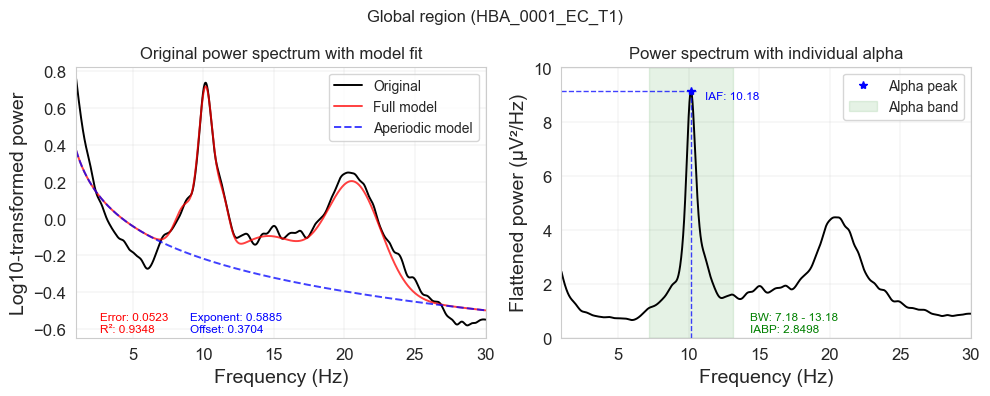

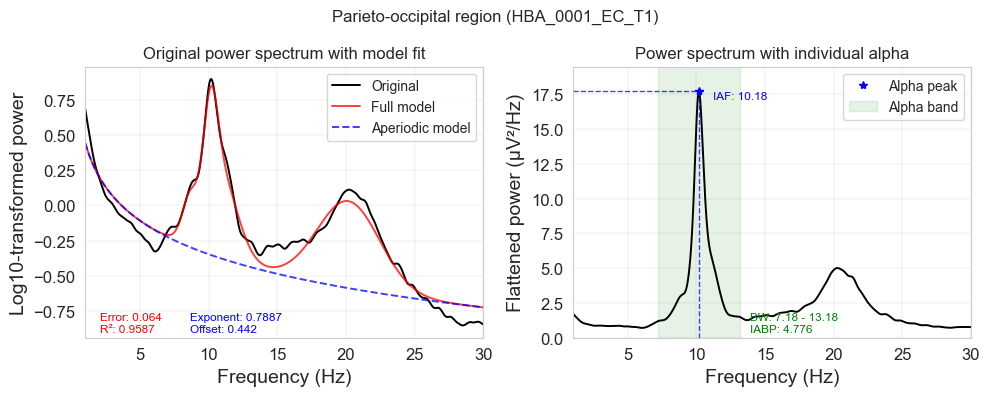

,Exponent,Offset,Alpha CF,Alpha PW,Alpha BW,Alpha absolute power,Alpha relative power,R_2,Error
HBA_0001_EC_T1,0.588513,0.370367,10.18,9.129576,"[7.18, 13.18]",2.849826,1.462443,0.934832,0.052348


,Exponent,Offset,Alpha CF,Alpha PW,Alpha BW,Alpha absolute power,Alpha relative power,R_2,Error
HBA_0001_EC_T1,0.788678,0.441988,10.18,17.703511,"[7.18, 13.18]",4.776013,2.038118,0.958735,0.063982


In [6]:
# Set the directory in progress and find all FIF (clean EEG) files in there
dir_inprogress = os.path.join(clean_folder, exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress, '_clean-epo.fif')
arrange.create_results_folders(exp_folder=exp_folder, results_folder=results_folder, fooof=True)

if savespectrum == True:
    try:
        os.makedirs(os.path.join('{}/{}/{}'.format(spectra_folder, exp_folder, spectrum_name)))
    except FileExistsError:
        pass
    try:
        os.makedirs(os.path.join('{}/{}/{}'.format(results_folder, exp_folder, spectrum_name)))
    except FileExistsError:
        pass

for i in range(len(file_dirs)):
    # Read in the clean EEG data
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress, subject_names[i]),
                                                                verbose=False)
    
    # Calculate Welch's power spectrum density
    [psds,freqs] = spectr.calculate_psd(epochs, subject_names[i], method=psd_params['method'],
                                        fminmax=psd_params['fminmax'], window=psd_params['window'],
                                        window_duration=psd_params['window_duration'],
                                        window_overlap=psd_params['window_overlap'],
                                        zero_padding=psd_params['zero_padding'],
                                        verbose=True, plot=False)
    
    # Average all epochs and channels together -> (freq bins,) shape
    if i == 0:
        psds_allch = np.zeros(shape=(len(file_dirs), len(freqs)))
    psds_allch[i] = psds.mean(axis=(0, 1))

    # Average all epochs together for each channel and also for each region
    psds = psds.mean(axis=(0))
    df_psds_ch = arrange.array_to_df(subject_names[i], epochs, psds).\
                            reset_index().drop(columns='Subject')
    df_psds_regions = arrange.df_channels_to_regions(df_psds_ch, brain_regions).\
                                reset_index().drop(columns='Subject')

    # Go through all regions of interest
    for region in df_psds_regions.columns:
        if i == 0:
            globals()["df_fooof_"+region] = pd.DataFrame(index=subject_names)
            globals()["df_powerspectra_"+region] = pd.DataFrame(columns=freqs, index=subject_names)
            globals()["df_flatpowerspectra_"+region] = pd.DataFrame(columns=freqs, index=subject_names)

        psds_temp = df_psds_regions[region].to_numpy()

        # Fit the spectrum with FOOOF (specparam)
        fm = FOOOF(**fooof_params, verbose=True)
        fm.fit(freqs, psds_temp, psd_params['fminmax'])
            
        # Log-linear conversion based on the chosen amplitude scale
        if ind_spectr_type == 'linear_flat':
            flatten_spectrum = 10 ** fm._spectrum_flat
            flat_spectr_ylabel = 'Flattened power (µV\u00b2/Hz)'
        elif ind_spectr_type == 'log_flat':
            flatten_spectrum = fm._spectrum_flat
            flat_spectr_ylabel = 'Flattened log10-transformed power'
        elif ind_spectr_type == 'linear_normal':
            flatten_spectrum = psds_temp
            flat_spectr_ylabel = 'Power (µV\u00b2/Hz)'
        elif ind_spectr_type == 'log_normal':
            flatten_spectrum = np.log10(psds_temp)
            flat_spectr_ylabel = 'Log10-transformed power'

        # Find individual alpha band parameters
        cf, pw, bw, abs_bp, rel_bp = spectr.find_ind_band(flatten_spectrum, freqs,
                                                            bands['Alpha'], bw_size=6)

        # Set plot styles
        data_kwargs = {'color' : 'black', 'linewidth' : 1.4, 'label' : 'Original'}
        model_kwargs = {'color' : 'red', 'linewidth' : 1.4, 'alpha' : 0.75, 'label' : 'Full model'}
        aperiodic_kwargs = {'color' : 'blue', 'linewidth' : 1.4, 'alpha' : 0.75,
                            'linestyle' : 'dashed', 'label' : 'Aperiodic model'}
        flat_kwargs = {'color' : 'black', 'linewidth' : 1.4}
        hvline_kwargs = {'color' : 'blue', 'linewidth' : 1.0, 'linestyle' : 'dashed', 'alpha' : 0.75}

        # Plot power spectrum model + aperiodic fit
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)
        plot_spectrum(fm.freqs, fm.power_spectrum,
                    ax=axs[0], **data_kwargs)
        plot_spectrum(fm.freqs, fm.fooofed_spectrum_,
                    ax=axs[0], **model_kwargs)
        plot_spectrum(fm.freqs, fm._ap_fit,
                    ax=axs[0], **aperiodic_kwargs)
        axs[0].set_xlim(psd_params['fminmax'])
        axs[0].grid(linewidth=0.2)
        axs[0].set_xlabel('Frequency (Hz)')
        axs[0].set_ylabel('Log10-transformed power')
        axs[0].set_title('Original power spectrum with model fit')
        axs[0].legend()
        
        # Flattened spectrum plot (i.e., minus aperiodic fit)
        plot_spectrum(fm.freqs, flatten_spectrum,
                    ax=axs[1], **flat_kwargs)
        axs[1].plot(cf, pw, '*', color='blue', label='{} peak'.format(list(bands.keys())[0]))
        axs[1].set_xlim(psd_params['fminmax'])
        if ind_spectr_type == 'linear_flat' or ind_spectr_type == 'linear_normal': 
            (axs[1].set_ylim([0, pw*1.1]))
        if ind_spectr_type == 'log_flat' or ind_spectr_type == 'log_normal':
            (axs[1].set_ylim([None, pw*1.1]))
        axs[1].axvline(x=cf, ymin=0, ymax=pw/(pw*1.1), **hvline_kwargs)
        axs[1].axhline(y=pw, xmin=0, xmax=cf/(psd_params['fminmax'][1]+1), **hvline_kwargs)
        axs[1].axvspan(bw[0], bw[1], alpha=0.1, color='green', label='{} band'.format(list(bands.keys())[0]))
        axs[1].grid(linewidth=0.2)
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel(flat_spectr_ylabel)
        axs[1].set_title('Power spectrum with individual alpha')
        axs[1].legend()

        # If true, plot all the exported variables on the plots
        if plot_rich == True:
            axs[0].annotate('Error: ' + str(np.round(fm.get_params('error'), 4)) +
                        '\nR\u00b2: ' + str(np.round(fm.get_params('r_squared'), 4)),
                        (0.1, 0.16), xycoords='figure fraction', color='red', fontsize=8.5)
            axs[0].annotate('Exponent: ' + str(np.round(fm.get_params('aperiodic_params','exponent'), 4)) +
                        '\nOffset: ' + str(np.round(fm.get_params('aperiodic_params','offset'), 4)),
                        (0.19, 0.16), xycoords='figure fraction', color='blue', fontsize=8.5)
            axs[1].text(cf+1, pw, 'IAF: '+str(np.round(cf, 4)),
                        verticalalignment='top', color='blue', fontsize=8.5)
            axs[1].annotate('BW: '+str(np.round(bw[0], 4))+' - '+str(np.round(bw[1], 4))+
                            '\nIABP: '+str(np.round(abs_bp, 4)),
                            (0.75, 0.16), xycoords='figure fraction', color='green', fontsize=8.5)
        
        plt.suptitle('{} region ({})'.format(region, subject_names[i]))
        plt.tight_layout()
        if savefig == True:
            plt.savefig(fname='{}/{}/FOOOF/{}_{}_{}_fooof.png'.format(results_folder, exp_folder,
                                                                        exp_condition, subject_names[i],
                                                                        region), dpi=300)
        plt.show()

        # Add model parameters to dataframe
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Exponent']\
                                                        = fm.get_params('aperiodic_params','exponent')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Offset']\
                                                        = fm.get_params('aperiodic_params','offset')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} CF'.\
                        format(list(bands.keys())[0])] = cf
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} PW'.\
                        format(list(bands.keys())[0])] = pw
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} BW'.\
                        format(list(bands.keys())[0])] = str(bw)
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} absolute power'.\
                        format(list(bands.keys())[0])] = abs_bp
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} relative power'.\
                        format(list(bands.keys())[0])] = rel_bp
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'R_2']\
                                                        = fm.get_params('r_squared')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Error']\
                                                        = fm.get_params('error')
        
        # Add the original and flattened power spectra to the dataframe
        globals()["df_powerspectra_"+region].loc[subject_names[i]] = fm.power_spectrum
        globals()["df_flatpowerspectra_"+region].loc[subject_names[i]] = flatten_spectrum

# Export aperiodic data for all regions
for region in df_psds_regions.columns:
    globals()["df_fooof_"+region].to_excel('{}/{}/FOOOF/{}_{}_{}_fooof.xlsx'.format(results_folder,
                                                                                exp_folder,
                                                                                exp_condition,
                                                                                region,
                                                                                ind_spectr_type))
    display(globals()["df_fooof_"+region])

    if savespectrum == True:
        globals()["df_powerspectra_"+region].to_excel('{}/{}/{}/{}_powerspectra_{}_{}.xlsx'.format(spectra_folder,
                                                                                                exp_folder,
                                                                                                spectrum_name,
                                                                                                exp_condition,
                                                                                                region,
                                                                                                ind_spectr_type))
        globals()["df_flatpowerspectra_"+region].to_excel('{}/{}/{}/{}_flatpowerspectra_{}_{}.xlsx'.format(spectra_folder,
                                                                                                        exp_folder,
                                                                                                        spectrum_name,
                                                                                                        exp_condition,
                                                                                                        region,
                                                                                                        ind_spectr_type))
        #display(globals()["df_powerspectra_"+region])
        #display(globals()["df_flatpowerspectra_"+region])

### PARTICIPANTS EXCLUSION & MASTER FILES

To ensure the quality of specparam models for further analysis, we visually inspect all models and flag certain ones for closer inspection based on their goodness of fit metrics provided by the algorithm. Models were flagged if their explained variance ($R^2) was ≤ 0.6 or Mean Absolute Error (MAE) was < 0.025 (indicating overfit) or > 0.100 (indicating underfit). Furthermore, subjects were excluded from further alpha activity analysis if they lacked a discernible alpha peak in the parieto-occipital region.

In [ ]:
# Read in aperiodic spectral analysis data for all groups and regions into one dataframe

# Get Excel files location
dir_inprogress, filename, condition = arrange.read_excel_psd(exp_folder+'/FOOOF',
                                                            results_folder,
                                                            condition_strsplit='_fooof')
df = pd.DataFrame()
for i, cond in enumerate(filename):
    print(filename[i])
    print(i)
    df_temp = pd.read_excel('{}/{}.xlsx'.format(dir_inprogress, filename[i]), index_col=0, engine='openpyxl')

    df_temp['Group'] = filename[i].split('_', 3)[0]
    df_temp['Timepoint'] = filename[i].split('_', 3)[1]
    df_temp['Region'] = filename[i].split('_', 3)[2]

    df = pd.concat([df, df_temp])

df.index = [int(x[4:8]) for x in df.index]